<a href="https://colab.research.google.com/github/Mahantesh-Pattadkal-1993/CounterFactuals_GANs/blob/main/Counterfactual_Computation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Setting up the path for GAN Training
import os
os.chdir('/content/gdrive/MyDrive/Github/CounterFactuals_GANs/MNIST')

In [4]:
#Import the libraries 
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from GAN_Models import DC_Generator, DC_Discriminator, Net, CNN, Net_logits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0




# Set random seed for reproducibility
manualSeed = 2021
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  2021


## Loading the Models


In [5]:
#Load the Generator  
# using the 150 epochs dataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

G = DC_Generator().to(device)
D = DC_Discriminator().to(device)


checkpoint = torch.load("Weights/G_checkpoint_latest_149.pth", map_location=torch.device('cuda'))
G.load_state_dict(checkpoint['state_dict'])

checkpoint = torch.load("Weights/D_checkpoint_latest_149.pth", map_location=torch.device('cuda'))
D.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [6]:
#Load the Classifier
Classifier_model = Net()
Classifier_checkpoint = torch.load("Weights/Classifier_CNN.pth", map_location=torch.device('cuda'))
Classifier_model.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
#Load the Classifier Net_logits() and outputs :- softmax, logits
Classifier_model_logits = Net_logits().to(device)
Classifier_checkpoint = torch.load("Weights/Classifier_CNN_logits.pth", map_location=torch.device('cuda'))
Classifier_model_logits.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model_logits.eval()

Net_logits(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
#Load Eoins Classifier
Classifier_model_eoin = CNN()
Classifier_checkpoint = torch.load("Weights/pytorch_cnn.pth", map_location=torch.device('cpu'))
#Classifier_model.load_state_dict(Classifier_checkpoint['state_dict'])
Classifier_model_eoin.eval()

# Gettin weird predictions, maybe the state dict is missing

CNN(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): Conv2d(64, 128, kernel_size=(

## Data Loaders

In [19]:
#Loading the data

mb_size = 4

transform = transforms.Compose(
		[transforms.ToTensor(),
		 transforms.Normalize((0.5,), (0.5,))])

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=False, batch_size=mb_size)

dataIter = iter(trainLoader)

imgs, labels = dataIter.next()
imgs = imgs.to(device)

print(imgs.shape)
print(labels)
imgs.is_cuda

torch.Size([4, 1, 28, 28])
tensor([5, 0, 4, 1])


True

tensor([[1.0000e+00, 8.4316e-11, 1.7799e-08, 5.8022e-12, 1.0353e-11, 1.9533e-13,
         2.2826e-09, 1.6658e-10, 1.5405e-11, 1.8834e-11]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


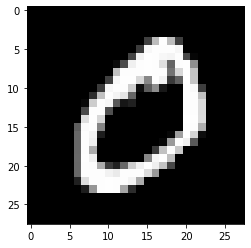

In [182]:
sample_image = imgs[1,:,:,:] #first image in this batch 
sample_image= sample_image.reshape([1,1,28,28]) #adding the dimension for batch size
sample_image = sample_image.to('cpu') #pushing it to cpu as that numpy conversion can be done


npimgs = sample_image[0].detach().numpy()
plt.imshow(npimgs[0],cmap='Greys_r')

sample_image = sample_image.to('cuda')
output, logits = Classifier_model_logits(sample_image)
print(output)

In [183]:
import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001

In [ ]:
#find the z_org that respresents the latent representation of given image

def latent_representation(z,sample_image,pred):
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(sample_image-G(z))).sum() 
    loss2 = torch.square(torch.abs(Classifier_model_logits(G(z))[0] - Classifier_model_logits(sample_image)[0]).sum())
    #loss2 = torch.square(torch.abs(Classifier_model_logits(G(z)) - Classifier_model_logits(sample_image)).sum()) # use when Net() model is used
    

    loss = loss1 + loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      
      overall_loss = 0 
    
    if(i==10000):
      break

  return z

z_org = latent_representation(z,sample_image,4)

G_img= G(z_org) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')




In [56]:
Classifier_model_logits(G(z))[0]

tensor([[1.3555e-06, 9.3431e-12, 2.9211e-12, 1.9332e-12, 3.1462e-12, 5.2353e-05,
         9.9993e-01, 1.9209e-13, 2.0184e-05, 2.9865e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

avg_loss step  500tensor(0.5528, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1000tensor(0.4814, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  1500tensor(0.4655, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  2000tensor(0.4573, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  2500tensor(0.4534, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  3000tensor(0.3609, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  3500tensor(0.2538, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  4000tensor(0.2368, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  4500tensor(0.2281, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  5000tensor(0.2193, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  5500tensor(0.2104, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  6000tensor(0.2013, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  6500tensor(0.1961, device='cuda:0', grad_fn=<DivBackward0>)
avg_loss step  7000tensor(

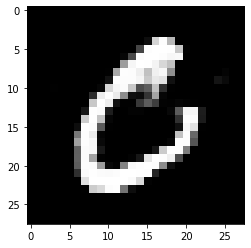

In [188]:
# Using the standard loss functions
#find the z_org that respresents the latent representation of given image

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
z= torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
MSE = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
optimizer = optim.SGD([z_semi], lr=0.01) #not using optimiser here


def latent_representation(z,sample_image):
  overall_loss, loss , avg_loss = 0,10,0
  i=1

  while (loss>=0.09):
    z.requires_grad = True
    loss1 = MSE(sample_image,G(z)) #pixel loss
    loss2 = MSE(Classifier_model_logits(G(z))[0] , Classifier_model_logits(sample_image)[0]) #diference in pred of both images
    
    loss = loss1 + loss2
    #print(loss)

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
            
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      overall_loss = 0 
    

  return z

z_org = latent_representation(z,sample_image)

G_img= G(z_org) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')




(1, 28, 28)


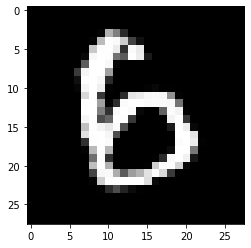

In [186]:
G_img= G(z) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')


## Latent dimension loss 

avg_loss step  500tensor(44.3367, grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor(11.3798, grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor(44.3367, grad_fn=<DivBackward0>)
avg_loss step  1500tensor(5.1295, grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor(11.3798, grad_fn=<DivBackward0>)
avg_loss step  2000tensor(4.1300, grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor(5.1295, grad_fn=<DivBackward0>)
avg_loss step  2500tensor(3.9595, grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor(4.1300, grad_fn=<DivBackward0>)
avg_loss step  3000tensor(3.9356, grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor(3.9595, grad_fn=<DivBackward0>)
avg_loss step  3500tensor(3.9402, grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor(3.9356, grad_fn=<DivBackward0>)
(1, 28, 28)


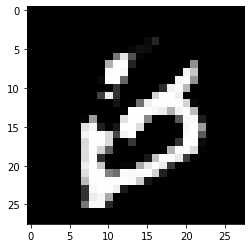

In [23]:
#using latent dimension euclidean distance and PR loss
import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001


def counterfactual_eluclidian(z,z_org,target_class):

  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(z_org-z)).sum() #latent dim euclidean loss
    loss2 = torch.log(Classifier_model_logits(G(z))[0][0][target_class]) #as classifier gives 2 outputs we take 0th index
    loss3 = torch.log(D(G(z))) #plausibility

    loss = loss1 - loss2 
    #loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  return z, loss1, loss2, loss3

target_class = 1
z_eucli, loss1, loss2, loss3 = counterfactual_eluclidian(z,z_org,target_class)
#Check if the image generated is close to the real image

G_img= G(z_eucli)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [24]:
Classifier_model_logits(G(z_eucli))[0]

tensor([[1.8972e-03, 4.9882e-01, 1.5683e-01, 6.7859e-02, 1.2414e-01, 2.1038e-05,
         1.3386e-01, 1.0421e-02, 6.0656e-03, 8.5337e-05]],
       grad_fn=<SoftmaxBackward>)

avg_loss step  500tensor(48.3900, grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor(16.9182, grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor(48.3900, grad_fn=<DivBackward0>)
avg_loss step  1500tensor(13.0249, grad_fn=<DivBackward0>)
avg_loss_old step 1500tensor(16.9182, grad_fn=<DivBackward0>)
avg_loss step  2000tensor(12.7657, grad_fn=<DivBackward0>)
avg_loss_old step 2000tensor(13.0249, grad_fn=<DivBackward0>)
avg_loss step  2500tensor(12.6995, grad_fn=<DivBackward0>)
avg_loss_old step 2500tensor(12.7657, grad_fn=<DivBackward0>)
avg_loss step  3000tensor(12.6908, grad_fn=<DivBackward0>)
avg_loss_old step 3000tensor(12.6995, grad_fn=<DivBackward0>)
avg_loss step  3500tensor(12.6878, grad_fn=<DivBackward0>)
avg_loss_old step 3500tensor(12.6908, grad_fn=<DivBackward0>)
avg_loss step  4000tensor(12.6876, grad_fn=<DivBackward0>)
avg_loss_old step 4000tensor(12.6878, grad_fn=<DivBackward0>)
avg_loss step  4500tensor(12.6864, grad_fn=<DivBackward0>)
avg_loss_o

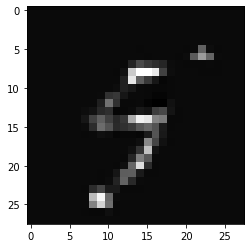

In [177]:
#using latent dimension distance and without PR loss

#This can be used as the baselines that do not talk about plausibility

import torch
torch.manual_seed(100)
z = torch.randn(1, 100,1,1).to(device)
step_size = 0.001


def counterfactual_eluclidian(z,z_org,target_class):

  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 = torch.square(torch.abs(z_org-z)).sum() 
    loss2 = torch.log(Classifier_model_logits(G(z))[0][0][target_class])
    loss3 = torch.log(D(G(z)))

    #loss = loss1 - 10*loss2 - loss3
    loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  return z

z = counterfactual_eluclidian(z,z_org,3)

#Check if the image generated is close to the real image
G_img= G(z)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [ ]:
#using latent dimension distance but cosine similarity
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def counterfactual_cosine(z,z_org,target_class):
  #print(target_class)
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z.requires_grad = True
    loss1 =  torch.log(0.1+torch.abs(cos(z_org,z)).mean())
    loss2 = torch.log(Classifier_model(G(z))[0][0][target_class])
    #print(Classifier_model(G(z))[0][target_class])
    loss3 = torch.log(D(G(z)))

    loss = -loss1 - loss2 - loss3
    #loss = loss1 - 10*loss2

    z.grad = None
    loss.backward()
    z.requires_grad = False
    z = z - z.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("loss2" + " " + str(loss2))
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
    if(i==10000):
      break
  
  return z, loss1, loss2, loss3


torch.manual_seed(100)
z= torch.randn(1, 100,1,1).to(device)
step_size = 0.01

target_class = 1
z_cf,loss1, loss2, loss3 = counterfactual_cosine(z,z_org,target_class)
#Check if the image generated is close to the real image

G_img= G(z_cf)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [ ]:
# Save the latent cfs for all the digits from 0-9
latent_cfs = []
for cnt in range(0,10,1):
  torch.manual_seed(100)
  z= torch.randn(1, 100,1,1).to(device)
  step_size = 0.01

  target_class = cnt
  z_cf,loss1, loss2, loss3 = counterfactual_cosine(z,z_org,target_class)
  latent_cfs.append(z_cf)

In [ ]:
G_img= G(latent_cfs[0])
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

(1, 28, 28)


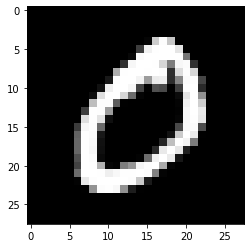

In [84]:
# Check how the original one looks
G_img= G(z_org)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

###Find the image which is on a borderline i.e. semi-factual

Idea: Use the metric **Pred - argmax2nd highest** to identify the borderline semi factual

avg_loss step  500tensor([14.4118], grad_fn=<DivBackward0>)
avg_loss_old step 5001000
avg_loss step  1000tensor([14.1344], grad_fn=<DivBackward0>)
avg_loss_old step 1000tensor([14.4118], grad_fn=<DivBackward0>)
(1, 28, 28)


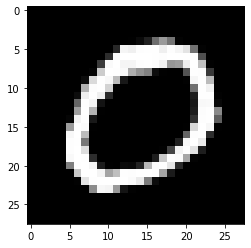

In [111]:
#Find the image distant from the original one but still has the same class perdiction

#using latent dimension distance
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

import torch
torch.manual_seed(100)
z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.01


def semifactuals(z_org,z_semi,given_class):
  overall_loss = 0
  loss = 0
  avg_loss = 1000
  avg_loss_old = 1000
  i=1
  while (avg_loss_old>=avg_loss):
    z_semi.requires_grad = True
    #loss1 = torch.square(torch.abs(z_org-z_semi)).sum() # distance in latent dimension euclidean
    
    loss1 =  torch.log(0.1+torch.abs(cos(z_org,z_semi)).mean()) # distance using cosine similarity
    loss2 = torch.log(Classifier_model(G(z_semi))[0][given_class]) # ensure the class is maintained 
    temp = Classifier_model(G(z_semi))[0]
    loss3 = torch.log(1.000001 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]])) # diference between highest and argmax 2
    loss4 = torch.log(D(G(z_semi))) # Plausibility

    
    
  #loss = loss1 - loss2 - 5*loss3 # without PR
    loss = -loss1 - loss2 - loss3 - loss4 #with PR
    z_semi.grad = None
    loss.backward()
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1

    overall_loss= overall_loss + loss
    if (i%500==0):
      #print("loss " + "step " + str(i) + str (loss))
      avg_loss_old = avg_loss
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
      print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
      overall_loss = 0 
  
    if (i==1000):
      break

  return z_semi

#-------------------------------------------------------------------
# Run the function from here
given_class = 0


z_semi = semifactuals(z_semi,z_org,given_class)

G_img= G(z_semi)
npimgs = G_img[0].detach().numpy()
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [105]:
Classifier_model(G(z_semi))[0]

tensor([1.0000e+00, 6.8261e-16, 2.3747e-12, 1.5510e-16, 7.7738e-18, 1.2519e-17,
        2.1426e-13, 8.3341e-14, 2.0627e-17, 7.0864e-16],
       grad_fn=<SelectBackward>)

In [106]:
torch.topk(Classifier_model(G(z_semi))[0],2)

torch.return_types.topk(values=tensor([1.0000e+00, 2.3747e-12], grad_fn=<TopkBackward>), indices=tensor([0, 2]))

In [107]:
torch.topk(Classifier_model(G(z_org))[0],2)

torch.return_types.topk(values=tensor([1.0000e+00, 6.3456e-13], grad_fn=<TopkBackward>), indices=tensor([0, 6]))

In [109]:
temp =   Classifier_model(G(z_semi))[0]
torch.log(1.000001 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]]))
1.1 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]])

tensor(0.1000, grad_fn=<RsubBackward1>)

###Find the image which is on a borderline i.e. semi-factual provided a target class

In [14]:
#Find the image distant from the original one but still has the same class perdiction
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

#using latent dimension distance

import torch
torch.manual_seed(100)
z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.001

given_class = 0

overall_loss = 0
loss = 0
avg_loss = 1000
avg_loss_old = 1000
i=1
while (avg_loss_old>=avg_loss):
  z_semi.requires_grad = True
  #loss1 = torch.square(torch.abs(z_org-z_semi)).sum() # distance in latent dimension
  
  loss1 = torch.log(0.1+torch.abs(cos(z_org,z_semi)).mean()) # distance using cosine similarity
  loss2 = torch.log(Classifier_model(G(z_semi))[0][0][given_class]) # ensure the class is maintained 
  #temp = Classifier_model(G(z_semi))[0]
  #loss3 = torch.log(1.1 - (temp[torch.topk(temp,2).indices[0]] - temp[torch.topk(temp,2).indices[1]])) # diference between highest and argmax 2
  loss3 = torch.log(1.0001 - torch.abs((Classifier_model(G(z_semi))[0][0] - Classifier_model(G(z_semi))[0][1]))) # difference between target class and img class
  loss4 = torch.log(D(G(z_semi))) # Plausibility

  
  
  loss = -loss1 - loss2 - loss3 -loss4 # without PR
  #loss = loss1 - loss2 - 5*loss3 - loss4 #with PR
  z_semi.grad = None
  loss.backward()
  z_semi.requires_grad = False
  z_semi = z_semi - z_semi.grad * step_size
  i = i+1

  overall_loss= overall_loss + loss
  if (i%500==0):
    #print("loss " + "step " + str(i) + str (loss))
    avg_loss_old = avg_loss
    avg_loss = overall_loss/500.0
    print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
    print("avg_loss_old " + "step " + str(i) + str (avg_loss_old))
    overall_loss = 0 
 

NameError: ignored

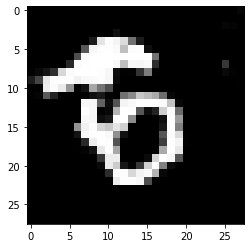

In [232]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided
G_img= G(z_semi)
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

## Using the standard losses for CF calculation

In [ ]:
#Using nn.losses

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)

  overall_loss = 0
  i=1
  while (i<=2500):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))

       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + 0.01*loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    overall_loss= overall_loss + loss 

    if (i%500==0):
           
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

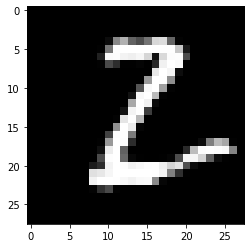

In [294]:
# Plotting the semi factual image according to the cf found by the latent dimension loss and target class provided
G_img= G(latent_z[40])
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

(1, 28, 28)


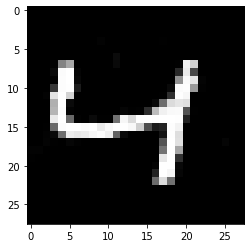

In [158]:


G_img= G(z_org) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [67]:
#Using nn.losses
#finding the journey of the digits after every 50 iterations

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z_journey = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)

  overall_loss = 0
  i=1
  while (i<=2500):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))

       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + 0.01*loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    overall_loss= overall_loss + loss 

    if (i%50==0):
           
      avg_loss = overall_loss/50.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
      latent_z_journey.append(z_semi)
  
  

tensor([[1.4459e-13, 4.2414e-08, 8.0479e-09, 9.9997e-01, 5.9251e-14, 4.1177e-09,
         2.8320e-14, 2.8318e-05, 1.5183e-10, 5.2207e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [91]:
# Plotting the counterfactual image iteration wise 
G_img= G(latent_z_journey[40])
G_img = G_img.to('cpu')
npimgs = G_img[0].detach().numpy()
#print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

tensor([[2.7616e-03, 3.0601e-05, 9.9420e-01, 2.9991e-03, 2.4383e-08, 2.4623e-07,
         4.0001e-06, 5.8101e-06, 7.3204e-08, 2.2983e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

## Semifactual calculation using standard losses

In [343]:
#Using nn.losses

import torch.optim as optim
import torch
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
torch.manual_seed(100)
#z_semi = torch.randn(1, 100,1,1).to(device)
step_size = 0.1

#Find the image closer to the original one but target prediction
criterion1 = nn.MSELoss()
nll = nn.NLLLoss()
CE_loss = nn.CrossEntropyLoss()
l1_loss = nn.L1Loss()
BCE = nn.BCELoss()
#optimizer = optim.SGD([z_semi], lr=0.01)


#using latent dimension distance
latent_z = []
for cnt in range(2,3,1):
  z_semi = z_org.to(device)
  arg_max = 0.01
  overall_loss = 0
  i=1
  
  while (torch.topk(Classifier_model_logits(G(z_semi))[0][0],2).indices[0] ==0 and torch.topk(Classifier_model_logits(G(z_semi))[0][0],2).indices[1] ==2  ):
    z_semi.requires_grad = True
        
    loss1 = criterion1(z_org,z_semi) # distance using MSE
    loss2 = CE_loss(Classifier_model_logits(G(z_semi))[1],torch.tensor([cnt]).to(device) ) # ensure the class is maintained 
    loss3 = BCE(D(G(z_semi)), torch.tensor([1.0]).to(device))
    arg_max = torch.argmax(Classifier_model_logits(G(z_semi))[0][0])
    print(arg_max)
       
    #loss =  loss1 + loss2  # without PR
    loss = loss1 + loss2 + 0.01*loss3 #with PR
    
    z_semi.grad = None
    loss.backward(retain_graph=True)  
    #optimizer.step()  
    z_semi.requires_grad = False
    z_semi = z_semi - z_semi.grad * step_size
    i = i+1
    print(i)
    overall_loss= overall_loss + loss 

    if (i%500==0):
           
      avg_loss = overall_loss/500.0
      print("avg_loss " + "step " + " " +str(i) + str (avg_loss))
     
      overall_loss = 0 
  latent_z.append(z_semi)
  
  

In [325]:
torch.abs(Classifier_model_logits(G(z_semi))[0][0][0] -Classifier_model_logits(G(z_semi))[0][0][2])

tensor(0.1284, device='cuda:0', grad_fn=<AbsBackward>)

In [340]:
Classifier_model_logits(G(z_semi))[0][0]


tensor([4.3783e-08, 1.6882e-01, 8.3117e-01, 2.4964e-08, 1.1351e-08, 3.9926e-10,
        6.2857e-07, 1.2927e-07, 7.4876e-08, 5.9644e-12], device='cuda:0',
       grad_fn=<SelectBackward>)

In [344]:
torch.topk(Classifier_model_logits(G(z_semi))[0][0],2).indices

torch.return_types.topk(values=tensor([0.9983, 0.0016], device='cuda:0', grad_fn=<TopkBackward>), indices=tensor([0, 6], device='cuda:0'))

(1, 28, 28)


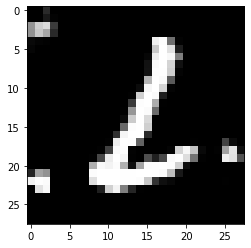

In [336]:


G_img= G(z_semi) #generate the img
G_img = G_img.to('cpu')  # bring it to cpu
npimgs = G_img[0].detach().numpy()  #plot the image
print(npimgs.shape)
plt.imshow(npimgs[0],cmap='Greys_r')

In [334]:
Classifier_model_logits(G(z_semi))[0]

tensor([[9.0800e-12, 5.5329e-08, 1.4080e-07, 2.9251e-06, 2.1534e-12, 1.7786e-12,
         1.8610e-13, 1.0000e+00, 9.9023e-12, 1.9158e-08]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [327]:
Classifier_model_logits(G(z_semi))[0][0][2]

tensor(0.1284, device='cuda:0', grad_fn=<SelectBackward>)